In [1]:
import numpy as np
from binomial import Binomial
from calibration import calibration
from rcn import rcn
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
"""Run callibration file and return the interest rate, div yield, u and d"""
r, y, u, d = calibration()

Interest rate  -0.0078
Dividend yield 0.0023
------------------------------
Minimum found!
Func value     0.2349
Up             1.0550
Down           0.9437
------------------------------


## Question 1

In [3]:
T = 12
dt = 1/T
i0 = 11118
c = 0.1
alpha = 1
beta = 0.8

In [4]:
tree = Binomial(r, T, dt, i0, u, d, y)

print('{:10} : {:.4f}'.format(' rcn', tree.price_RCN(alpha, c)))
print('{:10} : {:.4f}'.format('brcn', tree.price_RCN(alpha, c, beta)))
print('{:10} : {:.4f}'.format('bond', tree.price_bond(c*dt)))

print()
note = rcn(r, dt, i0, y, u, d, c, T)
print('{:10} : {:.4f}'.format(' rcn', note.price_rcn(alpha=alpha, c=c)))
print('{:10} : {:.4f}'.format('brcn', note.price_brcn(alpha=alpha, beta=beta, c=c)))
print('{:10} : {:.4f}'.format('bond', note.bond))


 rcn       : 1.0117
brcn       : 1.0443
bond       : 1.1083

 rcn       : 1.0117
brcn       : 1.0443
bond       : 1.1083


## Question 2

In [5]:
par_price = 1

def f(c, *args):
    alpha, beta, type = args
    if type == 'RCN': p = tree.price_RCN(alpha, c)
    if type == 'BRCN': p = tree.price_RCN(alpha, c, beta)
    return (par_price - p) ** 2

res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN'))
print('alpha = {}, beta = {}'.format(alpha, beta))
if res_RCN.success: print('Par coupon for RCN:  c = {:.2%}'.format(res_RCN.x[0]))
if res_BRCN.success: print('Par coupon for BRCN: c = {:.2%}'.format(res_BRCN.x[0]))

alpha = 1, beta = 0.8
Par coupon for RCN:  c = 8.83%
Par coupon for BRCN: c = 5.58%


In [6]:
res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
rates = [0.4,0.6,0.8,1]
alphas = np.linspace(0.6, 1, 10)
betas = np.outer(alphas, rates)

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x - 0})

rcn_c = []
brcn_c = np.zeros_like(betas)

for i, b in enumerate(tqdm(betas)):
    alpha = alphas[i]
    res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'), constraints=cons)
    rcn_c.append(res_RCN.x[0]*100)
    for j, beta in enumerate(b):
        res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN'), constraints=cons)
        brcn_c[i,j] = res_BRCN.x[0]*100

100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


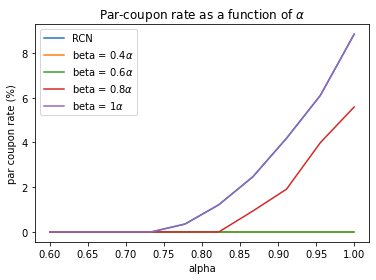

In [7]:
plt.plot(alphas, rcn_c)
for c in brcn_c.T:
    plt.plot(alphas, c)
plt.xlabel('alpha')
plt.ylabel('par coupon rate (%)')
plt.legend(['RCN'] + [r'beta = {}$\alpha$'.format(r) for r in rates])
plt.title(r'Par-coupon rate as a function of $\alpha$')
plt.show()

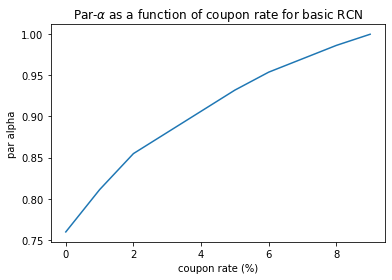

In [8]:
coupons = np.linspace(0, 0.09, 10)
par_price = 1


cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x - 0})

def g(alpha, *args):
    c, = args
    return (par_price - tree.price_RCN(alpha, c)) ** 2

alphas = []
for c in coupons:
    res = minimize(g, 1, args=(c), constraints=cons)
    alphas.append(res.x[0])

plt.plot(coupons*100, alphas)
plt.xlabel('coupon rate (%)')
plt.ylabel('par alpha')
plt.title(r'Par-$\alpha$ as a function of coupon rate for basic RCN')
plt.show(tree.price_RCN(alpha, c))

In [9]:
def h(alpha, *args):
    c, rate = args
    return (par_price - tree.price_RCN(alpha, c, rate*alpha)) ** 2


coupons = np.linspace(0, 0.09, 10)
rates = [0.4, 0.6, 0.8, 1]
#betas = np.outer(coupons, rates)

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x - 0})

brcn_alpha = []

for i, r in enumerate(rates):
    row= []
    for j, c in enumerate(tqdm(coupons)):
        c = coupons[j]
        if r==0.4 or r==0.6:
            start = 1
        else:
            start=0.85
        res_BRCN = minimize(h, start, args=(c, r), constraints=cons)
        row.append(res_BRCN.x[0])
        #print(res_BRCN.x[0])
    # print(row)
    brcn_alpha.append(row)
# print(brcn_alpha)

100%|██████████| 10/10 [00:49<00:00,  5.00s/it]


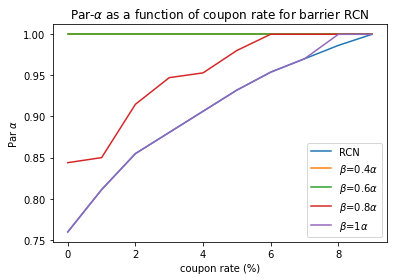

In [10]:
plt.plot(coupons*100, alphas, label='RCN')

for i, r in enumerate(rates):
    plt.plot(coupons*100, brcn_alpha[i], label=r'$\beta$={}$\alpha$'.format(r))
    plt.xlabel('coupon rate (%)')
    plt.ylabel(r'Par $\alpha$')

plt.title(r'Par-$\alpha$ as a function of coupon rate for barrier RCN')
plt.legend()
plt.show()

#Q6-7-8

In [11]:
dates = [i for i in range(int(T/dt)+1)]
alpha = 1
c = 0.1
beta = 0.8
dates = [j for j in range(1, T)]
RCN = note.price_rcn(alpha=alpha, c=c, dates=dates)
BRCN = note.price_brcn(alpha=alpha, c=c, beta=0.8, dates=dates)
print('Price of callable simple RCN {:.4f}\nPrice of callable barrier RCN {:.4f}'.format(RCN, BRCN))

Price of callable simple RCN 0.9920
Price of callable barrier RCN 0.9995


In [12]:
par_price = 1

def f(c, *args):
    alpha, beta, type, dates = args
    if type == 'RCN': p = note.price_rcn(alpha, c, dates)
    if type == 'BRCN': p = note.price_brcn(alpha, beta, c, dates)
    return (par_price - p) ** 2

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x })


rates = [0.4,0.6,0.8,1]
alphas = np.linspace(0.6, 1, 10)
betas = np.outer(alphas, rates)

rcn_c = []
brcn_c = np.zeros_like(betas)

for i, b in enumerate(tqdm(betas)):
    alpha = alphas[i]
    res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN', dates), constraints=cons)
    rcn_c.append(res_RCN.x[0]*100)
    for j, beta in enumerate(b):
        res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN', dates), constraints=cons)
        brcn_c[i,j] = res_BRCN.x[0]*100

100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


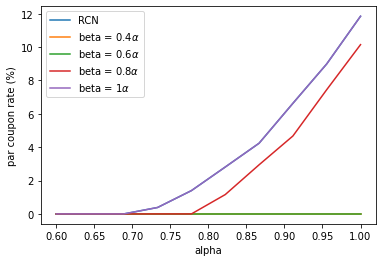

In [13]:
plt.plot(alphas, rcn_c)
for c in brcn_c.T:
    plt.plot(alphas, c)
plt.xlabel('alpha')
plt.ylabel('par coupon rate (%)')
plt.legend(['RCN'] + [r'beta = {}$\alpha$'.format(r) for r in rates])
plt.show()

Grid Search

In [14]:
coupons = np.linspace(0., 0.12, 15)
alphas = np.linspace(0.6, 1, 100)
rates = [0.4, 0.6, 0.8, 1]

par_alph = np.zeros([len(rates), coupons.shape[0]])
for n, r in enumerate(rates):
    dist = np.zeros([alphas.shape[0], coupons.shape[0]])
    for j, c in enumerate(tqdm(coupons)):
        for i, a in enumerate(alphas):
            p = note.price_brcn(a, r*a, c, dates)
            dist[i, j] = (1 - p)**2
    min_alpha_ind = np.argmin(dist, axis=0)
    par_alph[n, :] = alphas[min_alpha_ind]

100%|██████████| 15/15 [01:33<00:00,  6.23s/it]


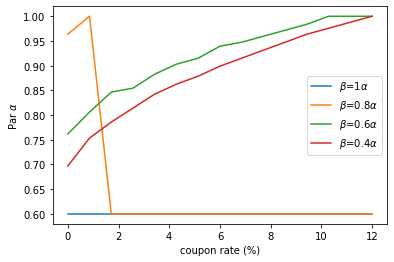

In [15]:
for i, r in enumerate(reversed(rates)):
    plt.plot(coupons*100,  par_alph[i], label=r'$\beta$={}$\alpha$'.format(r))
    plt.xlabel('coupon rate (%)')
    plt.ylabel(r'Par $\alpha$')

plt.legend()
plt.show()